In [1]:
from eazy.photoz import template_lsq
import astropy.units as u
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
from BDFit import StarFit
import fnmatch
from astropy.table import Table

In [2]:
s = StarFit(libraries=['sonora_bobcat'])

Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 1208


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='F444W - F356W', ylabel='F444W - F410M'>)

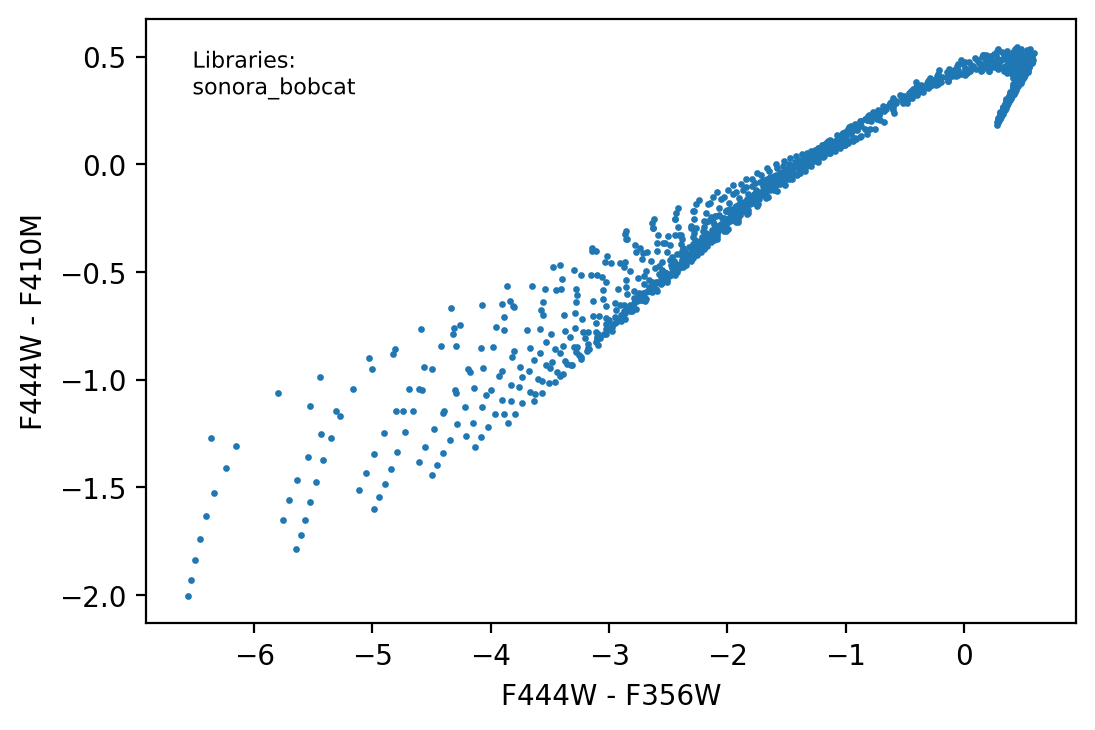

In [3]:
s.color_color('F444W - F356W', 'F444W - F410M', s=2)

In [4]:
def find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr'):#, error_wildcard='FLUXERR_APER_*_loc_depth'):
    # glob-like matching for column names
    flux_columns = fnmatch.filter(table.colnames, flux_wildcard)
    # get the band names from the column names
    flux_split = flux_wildcard.split('*')
    flux_bands = [col.replace(flux_split[0], '').replace(flux_split[1], '') for col in flux_columns]
    return flux_bands

def provide_phot(table, bands=None, flux_wildcard='FLUX_APER_*_aper_corr_Jy', error_wildcard='FLUXERR_APER_*_loc_depth_10pc_Jy', min_percentage_error=0.1, flux_unit=u.Jy, multi_item_columns_slice=None):
    
    if bands is None:
        bands = find_bands(table)

    flux_columns = [flux_wildcard.replace('*', band) for band in bands]
    error_columns = [error_wildcard.replace('*', band) for band in bands]

    print(flux_columns)
    assert all([col in table.colnames for col in flux_columns]), f'Flux columns {flux_columns} not found in table'
    assert all([col in table.colnames for col in error_columns]), f'Error columns {error_columns} not found in table'

    if multi_item_columns_slice is not None:
        fluxes = np.array([table[flux_column][:, multi_item_columns_slice] for flux_column in flux_columns]) * flux_unit
        errors = np.array([table[error_column][:, multi_item_columns_slice] for error_column in error_columns]) * flux_unit
    else:
        flux_data = table[flux_columns].as_array()
        error_data = table[error_columns].as_array()
        fluxes = structured_to_unstructured(flux_data) * flux_unit
        errors = structured_to_unstructured(error_data) * flux_unit

    mask = ((errors / fluxes) < min_percentage_error) & (fluxes > 0)
    errors[mask] = fluxes[mask] * min_percentage_error

    return fluxes, errors

In [5]:
s.get_mass_radius(0, plot_grid=False)

[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
Grid visualization saved to sonora_bobcat_flux_table_JWST+0.0_mass_radius_grid.png


(<Quantity 0.53 jupiterMass>, <Quantity 0.118 solRad>)

In [7]:
path = '/raid/scratch/work/tharvey/brown_dwarfs/hainline/jades_hainline_matched.fits'

cat = Table.read(path)

fluxes, errors = provide_phot(cat, multi_item_columns_slice=0)
bands = find_bands(cat)
bands = [band.upper() for band in bands]



['FLUX_APER_f606W_aper_corr_Jy', 'FLUX_APER_f090W_aper_corr_Jy', 'FLUX_APER_f115W_aper_corr_Jy', 'FLUX_APER_f150W_aper_corr_Jy', 'FLUX_APER_f200W_aper_corr_Jy', 'FLUX_APER_f277W_aper_corr_Jy', 'FLUX_APER_f335M_aper_corr_Jy', 'FLUX_APER_f356W_aper_corr_Jy', 'FLUX_APER_f410M_aper_corr_Jy', 'FLUX_APER_f444W_aper_corr_Jy']


In [8]:
s.fit_catalog(fnu=fluxes.T, efnu=errors.T, bands=bands, dump_fit_results=False)

Warning! Assuming F606W is the same as ACS_WFC.F606W
Fitting with sonora_bobcat libraries with 43 templates.
Fitting 10 bands: ['ACS_WFC.F606W', 'F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F335M', 'F356W', 'F410M', 'F444W']


Calculating chi2 for all templates...: 100%|██████████| 1208/1208 [00:00<00:00, 71559.79it/s]


{'subset': None,
 'star_tnorm': array([[2.75171898e+02, 4.17967102e+02, 2.06434808e+02, ...,
         1.11617260e-02, 1.15634065e-02, 1.17038582e-02],
        [1.56039173e+01, 2.36224282e+01, 1.17331606e+01, ...,
         1.53512375e-04, 1.48821396e-04, 1.49088276e-04],
        [3.89521086e+00, 5.90531156e+00, 2.92646563e+00, ...,
         1.02287465e-04, 1.01709378e-04, 1.03138296e-04],
        [4.70802386e+00, 7.07624244e+00, 3.56558223e+00, ...,
         4.49094587e-05, 4.41066812e-05, 4.40221158e-05]]),
 'star_chi2': array([[782.5936 , 792.1693 , 761.843  , ..., 282.69092, 270.6112 ,
         268.77853],
        [505.4743 , 516.75415, 481.29932, ..., 348.52832, 357.6061 ,
         358.4497 ],
        [488.339  , 498.77917, 465.91986, ..., 262.2362 , 264.79132,
         263.9567 ],
        [159.82587, 174.91245, 126.93999, ..., 255.17548, 255.76486,
         256.54813]], dtype=float32),
 'star_min_ix': array([803, 578, 666, 336]),
 'star_min_chi2': array([19.895416 ,  7.886077 ,  6.

 We can also calculate physical parameters, such as mass, radius and distance from the best fit template and it's normalization.

In [10]:
s.get_catalog_physical_params()

[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0,

(<Quantity [ 241.19535204,  767.61732715, 2219.86660346,  655.74629919] pc>,
 <Quantity [0.06888671, 0.03037519, 0.01414192, 0.04216828] solMass>,
 <Quantity [0.07731152, 0.0912    , 0.1107102 , 0.0804874 ] solRad>)

[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0,

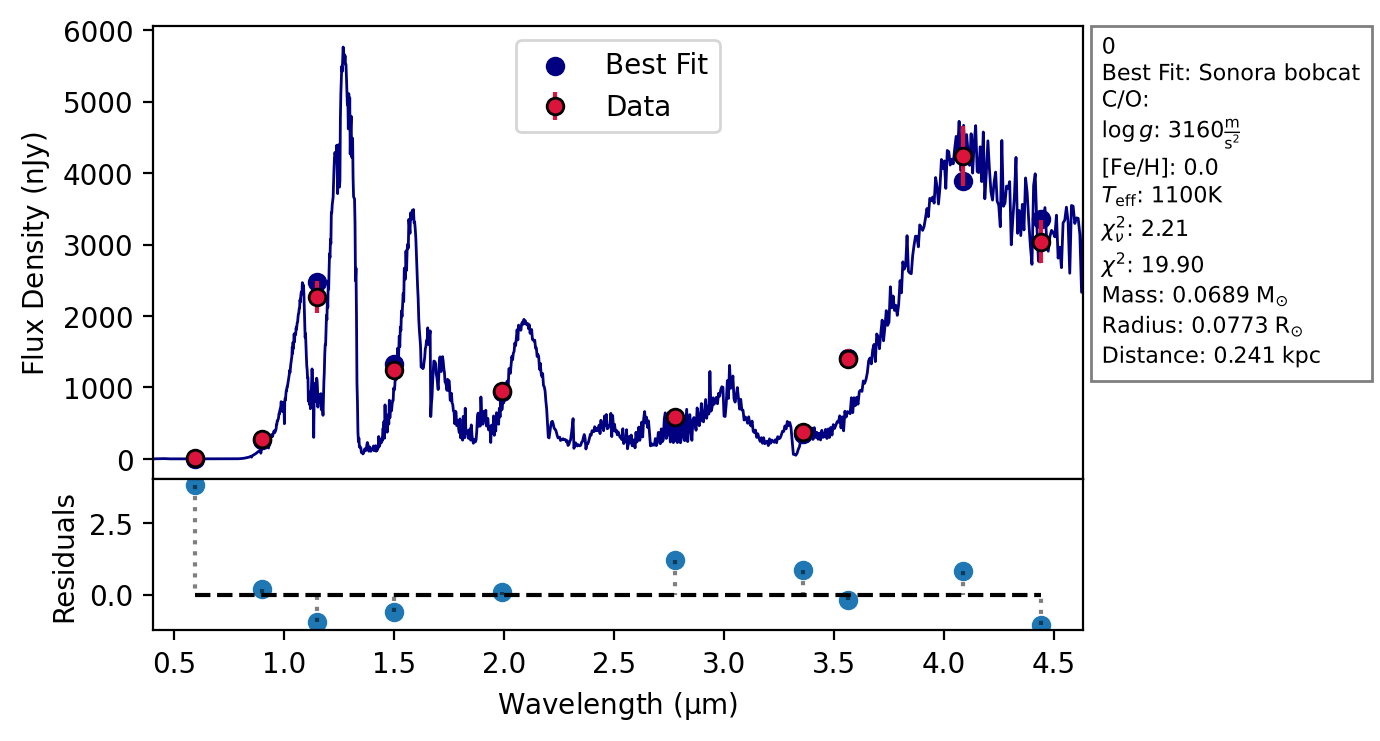

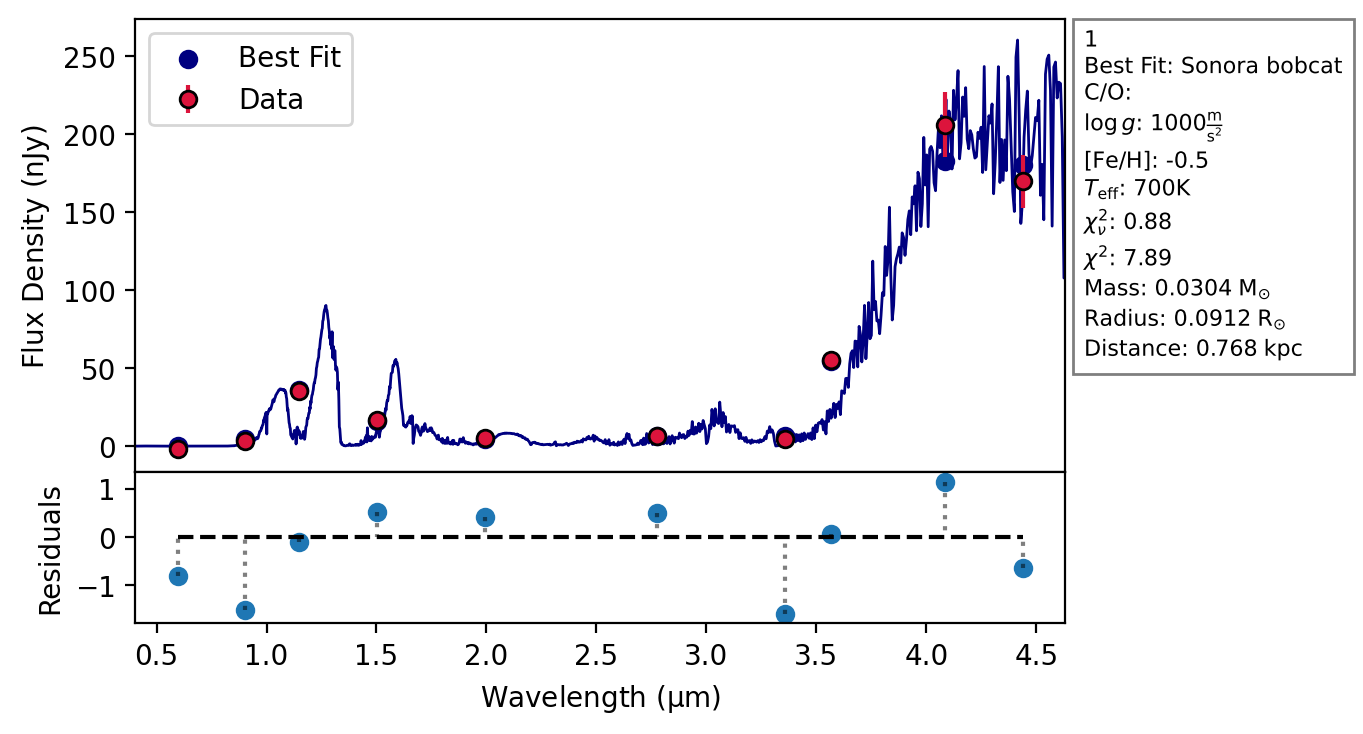

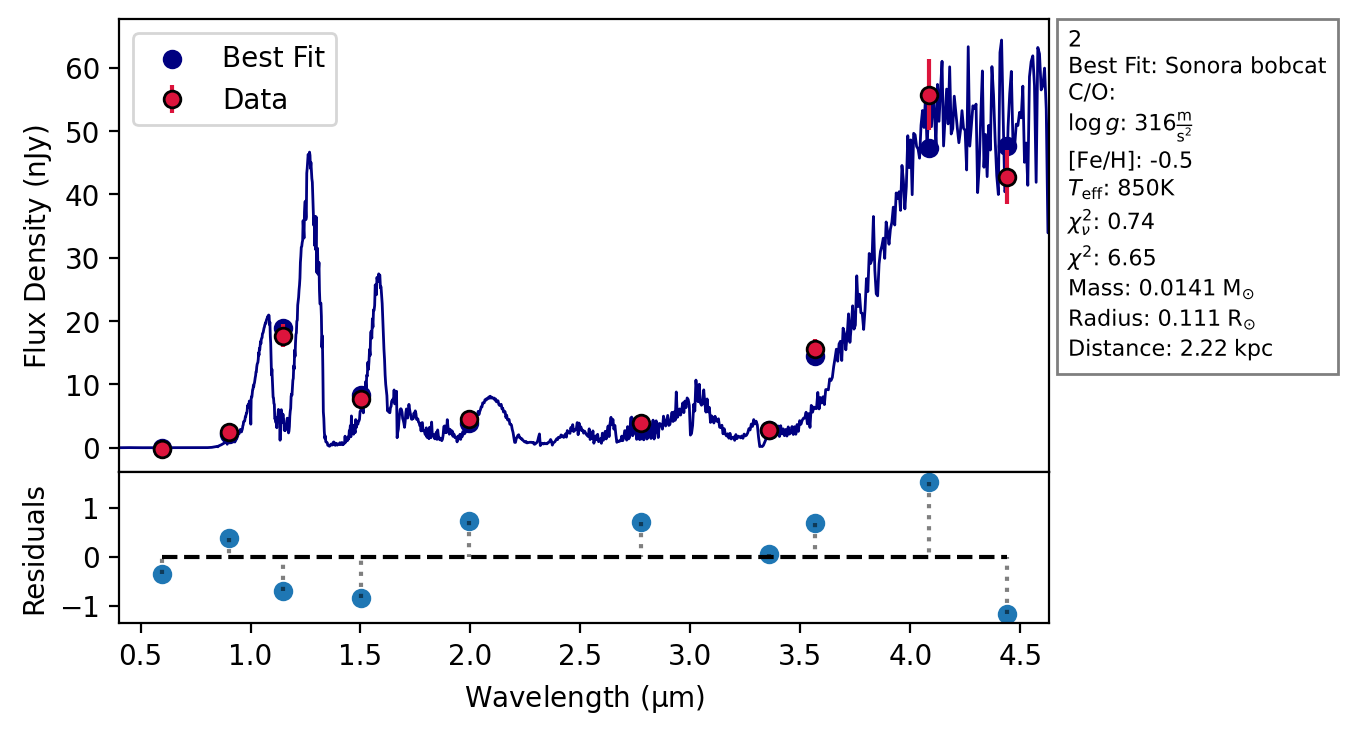

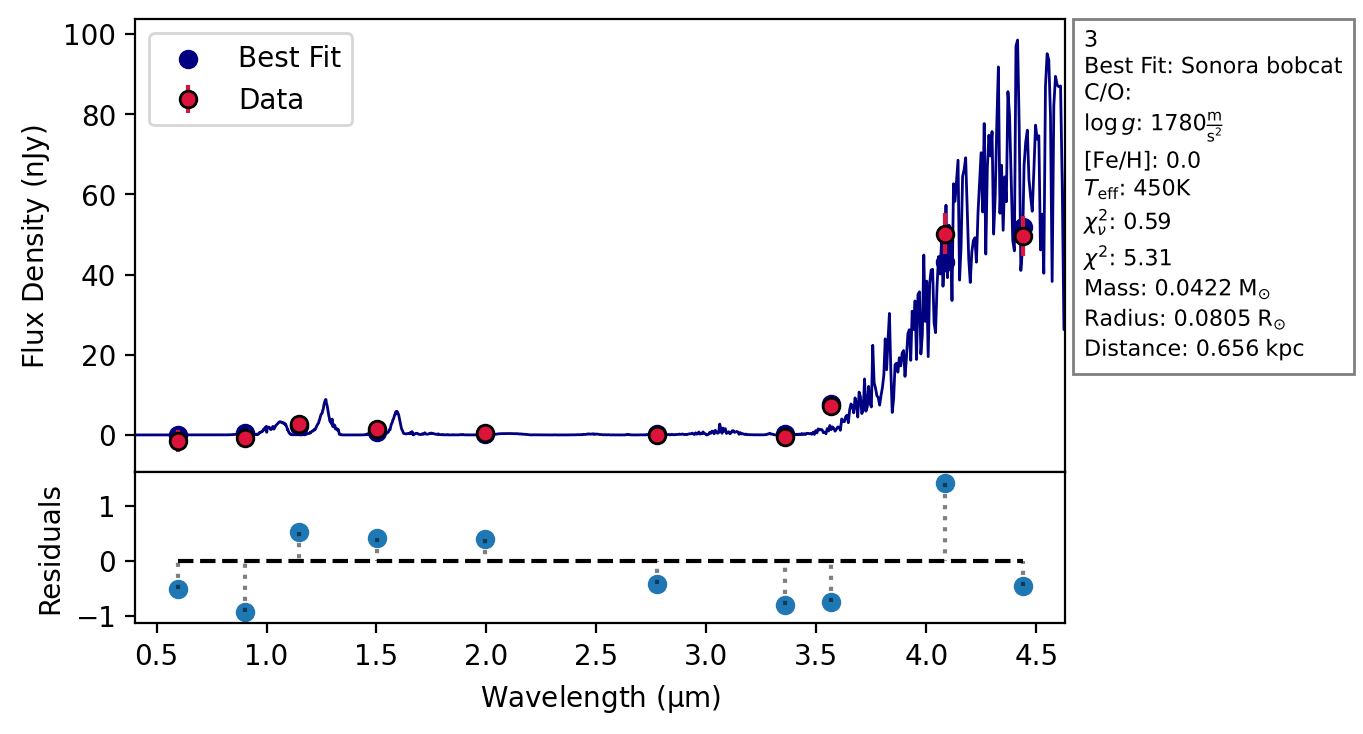

In [11]:
for i in range(len(cat)):
    s.plot_fit(idx=i)

In [12]:
from astropy.units import Quantity
help(Quantity.to_string)

Help on function to_string in module astropy.units.quantity:

to_string(self, unit=None, precision=None, format=None, subfmt=None)
    Generate a string representation of the quantity and its unit.
    
    The behavior of this function can be altered via the
    `numpy.set_printoptions` function and its various keywords.  The
    exception to this is the ``threshold`` keyword, which is controlled via
    the ``[units.quantity]`` configuration item ``latex_array_threshold``.
    This is treated separately because the numpy default of 1000 is too big
    for most browsers to handle.
    
    Parameters
    ----------
    unit : unit-like, optional
        Specifies the unit.  If not provided,
        the unit used to initialize the quantity will be used.
    
    precision : number, optional
        The level of decimal precision. If `None`, or not provided,
        it will be determined from NumPy print options.
    
    format : str, optional
        The format of the result. If not p

[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0]
[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0, 600.0, 650.0, 700.0,

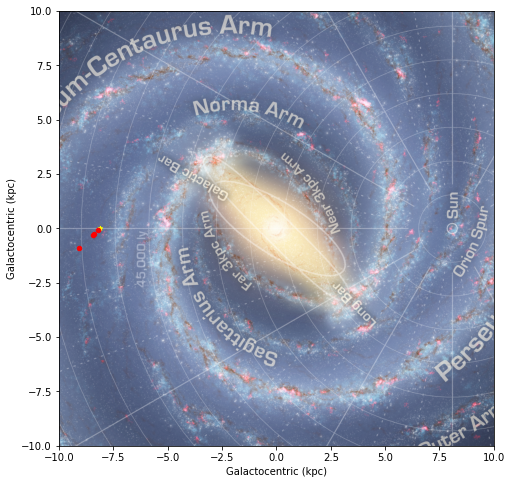

In [13]:
ra = cat['ALPHA_J2000'] * u.deg
dec = cat['DELTA_J2000'] * u.deg


ax = s.plot_brown_dwarf_locations(ra, dec, coord_system='galactocentric')

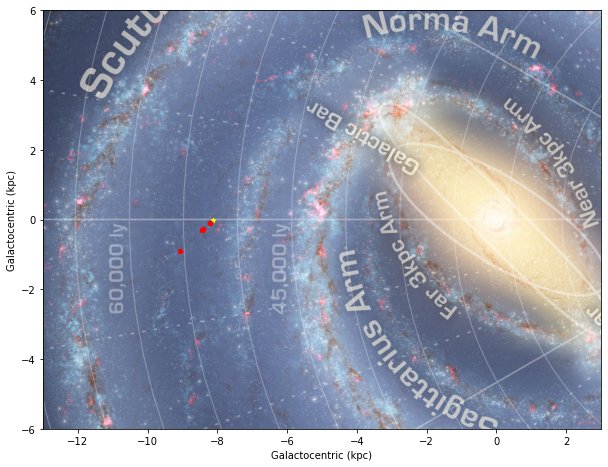

In [14]:
ax.ax.set_xlim(-13, 3)
ax.ax.set_ylim(-6, 6)
ax.fig.set_facecolor('white')
ax.fig